# Zoo Dataset Classification (Multilingual Version)

I'll approach this as a multilingual classification problem where we need to classify animals based on attributes that might be noisy due to translation. Let's break this down step by step, explaining the theory and approaches while highlighting potential pitfalls.

### 1. Understanding the Problem

In this project, we're working with the Zoo dataset but with a multilingual twist. The challenge is to classify animals correctly even when their attributes have been translated (potentially introducing noise or inconsistencies).

In [1]:
!pip3 install pandas seaborn matplotlib

### 2. Data Collection and Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
column_names = ['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne', 
                'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 
                'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']
zoo_df = pd.read_csv(url, names=column_names)

print(f"Dataset shape: {zoo_df.shape}")
print(zoo_df.head())
print(zoo_df['class_type'].value_counts())

Dataset shape: (101, 18)
  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   
3        bear     1         0     0     1         0        0         1   
4        boar     1         0     0     1         0        0         1   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  \
0        1         1         1         0     0     4     0         0        1   
1        1         1         1         0     0     4     1         0        1   
2        1         1         0         0     1     0     1         0        0   
3        1         1         1         0     0     4     0         0        1   
4        1         1         1         0     0     4     1         0        1   

   class_type  
0           1  
1          

### 3. Creating Multilingual Versions

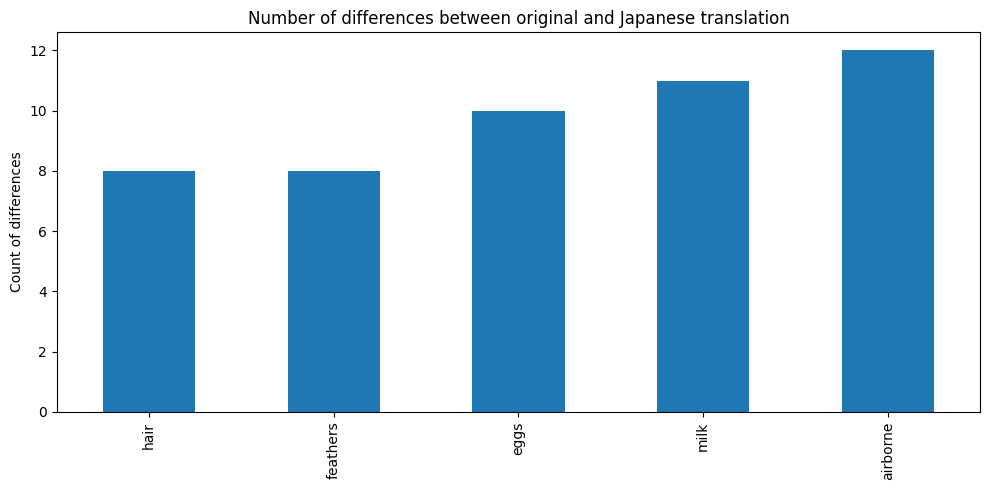

In [3]:
def simulate_translation(data, noise_level=0.1):
    noisy_data = data.copy()
    
    binary_cols = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 
                   'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 
                   'venomous', 'fins', 'tail', 'domestic', 'catsize']
    
    for col in binary_cols:
        flip_mask = np.random.random(len(data)) < noise_level
        noisy_data.loc[flip_mask, col] = 1 - noisy_data.loc[flip_mask, col]
    
    noisy_data['legs'] = noisy_data['legs'] + np.random.normal(0, noise_level * 2, len(data))
    noisy_data['legs'] = np.round(noisy_data['legs']).clip(0).astype(int)
    
    return noisy_data

languages = {
    'Original': zoo_df,
    'Spanish': simulate_translation(zoo_df, 0.05),
    'French': simulate_translation(zoo_df, 0.08),
    'Japanese': simulate_translation(zoo_df, 0.1),
    'Arabic': simulate_translation(zoo_df, 0.15)
}
def compare_datasets(original, translated, language):
    binary_cols = ['hair', 'feathers', 'eggs', 'milk', 'airborne']
    
    differences = (original[binary_cols] != translated[binary_cols]).sum()
    
    plt.figure(figsize=(10, 5))
    differences.plot(kind='bar')
    plt.title(f'Number of differences between original and {language} translation')
    plt.ylabel('Count of differences')
    plt.tight_layout()
    plt.show()

compare_datasets(languages['Original'], languages['Japanese'], 'Japanese')

### 4. Feature Engineering and Preprocessing

In [4]:
def preprocess_data(df):
    X = df.drop(['animal_name', 'class_type'], axis=1)
    y = df['class_type']
    
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled['legs'] = scaler.fit_transform(X[['legs']])
    
    return X, X_scaled, y

X_dict = {}
X_scaled_dict = {}
y_dict = {}

for lang, data in languages.items():
    X_dict[lang], X_scaled_dict[lang], y_dict[lang] = preprocess_data(data)

###  5. Model Selection and Training

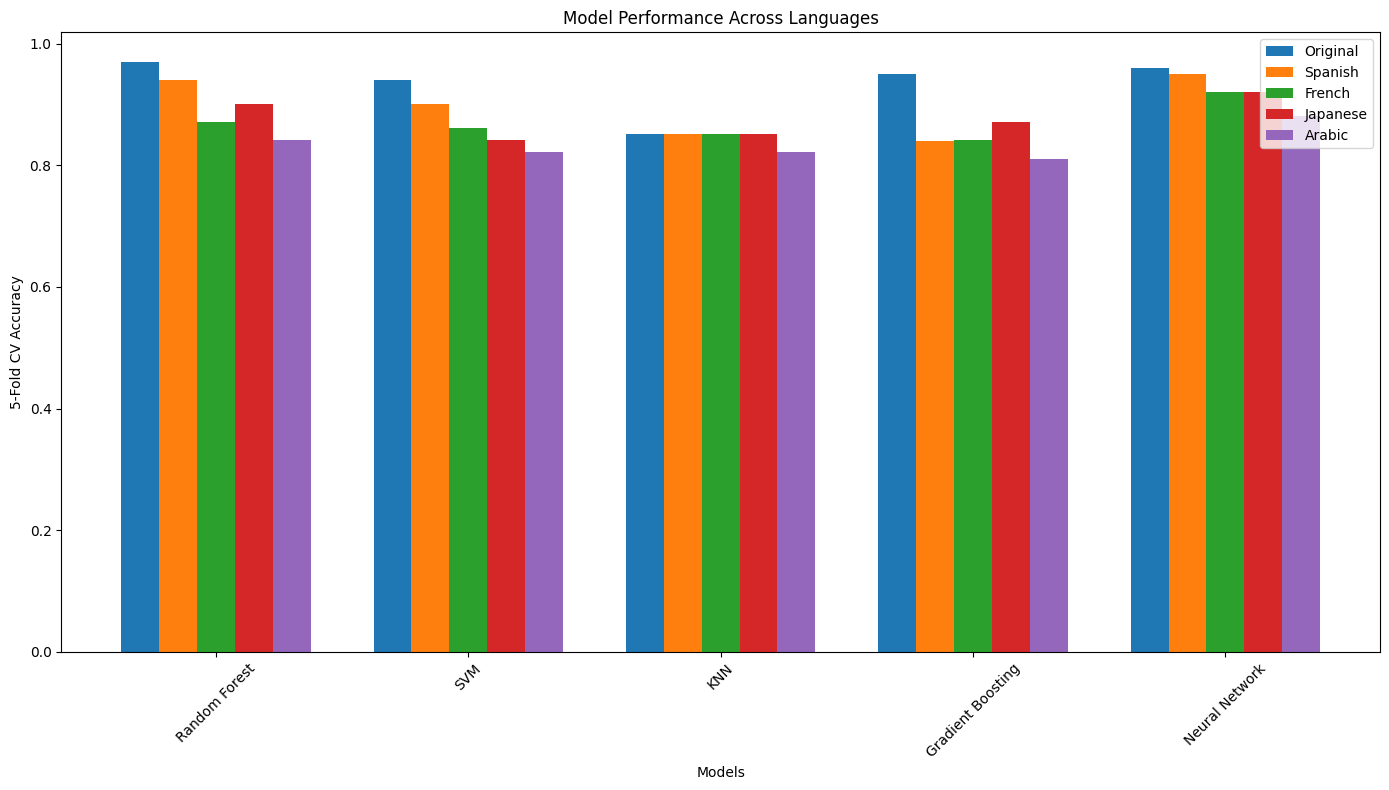

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}

results = {}

for lang in languages.keys():
    X = X_dict[lang]
    y = y_dict[lang]
    
    lang_results = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(model, X, y, cv=5)
        
        lang_results[name] = {
            'test_accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
    
    results[lang] = lang_results

def plot_results(results):
    plt.figure(figsize=(14, 8))
    
    for i, lang in enumerate(results.keys()):
        accuracies = [results[lang][model]['cv_mean'] for model in models.keys()]
        x = np.arange(len(models))
        width = 0.15
        
        plt.bar(x + i*width, accuracies, width, label=lang)
    
    plt.xlabel('Models')
    plt.ylabel('5-Fold CV Accuracy')
    plt.title('Model Performance Across Languages')
    plt.xticks(x + width*2, list(models.keys()), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(results)

### 6. Multilingual Model Training Strategy

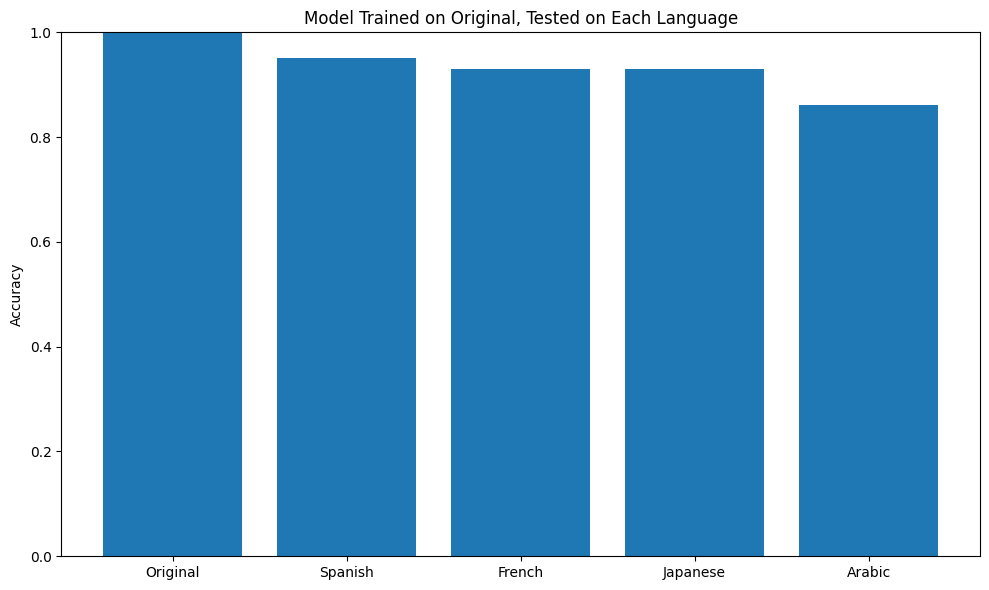

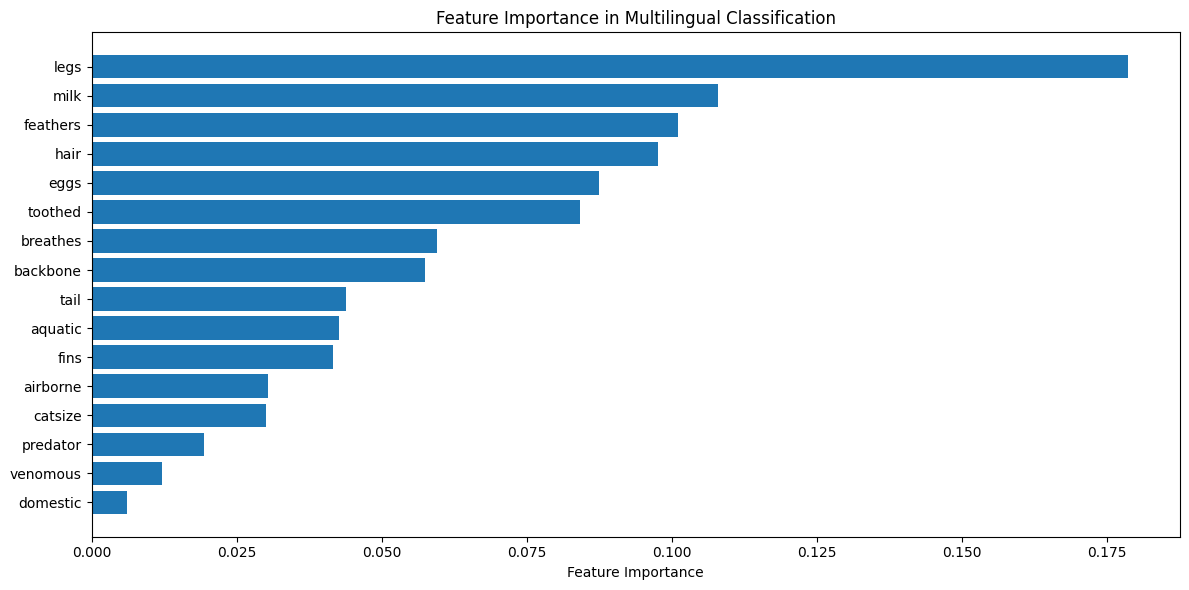

In [6]:
# Approach 1: Training on original data, testing on each language
def train_original_test_translated():
    # Using Random Forest as it generally performed well
    model = RandomForestClassifier(random_state=42)
    
    # Train on original data
    X_train = X_dict['Original']
    y_train = y_dict['Original']
    model.fit(X_train, y_train)
    
    # Test on each language
    lang_accuracies = {}
    for lang in languages.keys():
        X_test = X_dict[lang]
        y_test = y_dict[lang]
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        lang_accuracies[lang] = accuracy
    
    return lang_accuracies

# Approach 2: Combining training data (data augmentation)
def train_combined():
    # Combine data from all languages
    X_combined = pd.concat([X_dict[lang] for lang in languages.keys()])
    y_combined = pd.concat([y_dict[lang] for lang in languages.keys()])
    model = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(model, X_combined, y_combined, cv=5)
    model.fit(X_combined, y_combined)
    
    return {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'feature_importance': model.feature_importances_,
        'model': model
    }
approach1_results = train_original_test_translated()
approach2_results = train_combined()

plt.figure(figsize=(10, 6))
plt.bar(approach1_results.keys(), approach1_results.values())
plt.title('Model Trained on Original, Tested on Each Language')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
features = X_dict['Original'].columns
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(approach2_results['feature_importance'])
plt.barh(features[sorted_idx], approach2_results['feature_importance'][sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Multilingual Classification')
plt.tight_layout()
plt.show()


### 7. Advanced Approach: Robust Ensemble Method

In [7]:
from turtle import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier

class RobustMultilingualEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models=None, noise_levels=[0, 0.05, 0.1, 0.15]):
        self.base_models = base_models or {
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'svm': SVC(probability=True, random_state=42),
            'gb': GradientBoostingClassifier(random_state=42)
        }
        self.noise_levels = noise_levels
        self.models = {}
        
    def fit(self, X, y):
        for name, model in self.base_models.items():
            model.fit(X, y)
            self.models[f"{name}_original"] = model
        
        # Train models on augmented data with different noise levels
        for noise in self.noise_levels:
            if noise == 0:  # Skip as we already trained on original
                continue
                
            # Generate noisy version of the data
            X_noisy = pd.DataFrame(X.copy())
            
            # Apply noise similar to our simulate_translation function
            binary_cols = X_noisy.columns[X_noisy.isin([0, 1]).all()]
            for col in binary_cols:
                flip_mask = np.random.random(len(X)) < noise
                X_noisy.loc[flip_mask, col] = 1 - X_noisy.loc[flip_mask, col]
            
            # Handle numerical features
            num_cols = list(set(X_noisy.columns) - set(binary_cols))
            for col in num_cols:
                X_noisy[col] = X_noisy[col] + np.random.normal(0, noise * 2, len(X))
                if col == 'legs':  # Ensure legs remains an integer
                    X_noisy[col] = np.round(X_noisy[col]).clip(0).astype(int)
            
            # Train models on noisy data
            for name, model_template in self.base_models.items():
                model = clone(model_template)
                model.fit(X_noisy, y)
                self.models[f"{name}_noise_{noise}"] = model
        
        return self
    
    def predict_proba(self, X):
        all_probs = []
        
        for name, model in self.models.items():
            probs = model.predict_proba(X)
            all_probs.append(probs)
        
        avg_probs = np.mean(all_probs, axis=0)
        return avg_probs
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1) + 1

### 8. Model Evaluation and Cross-Language Testing

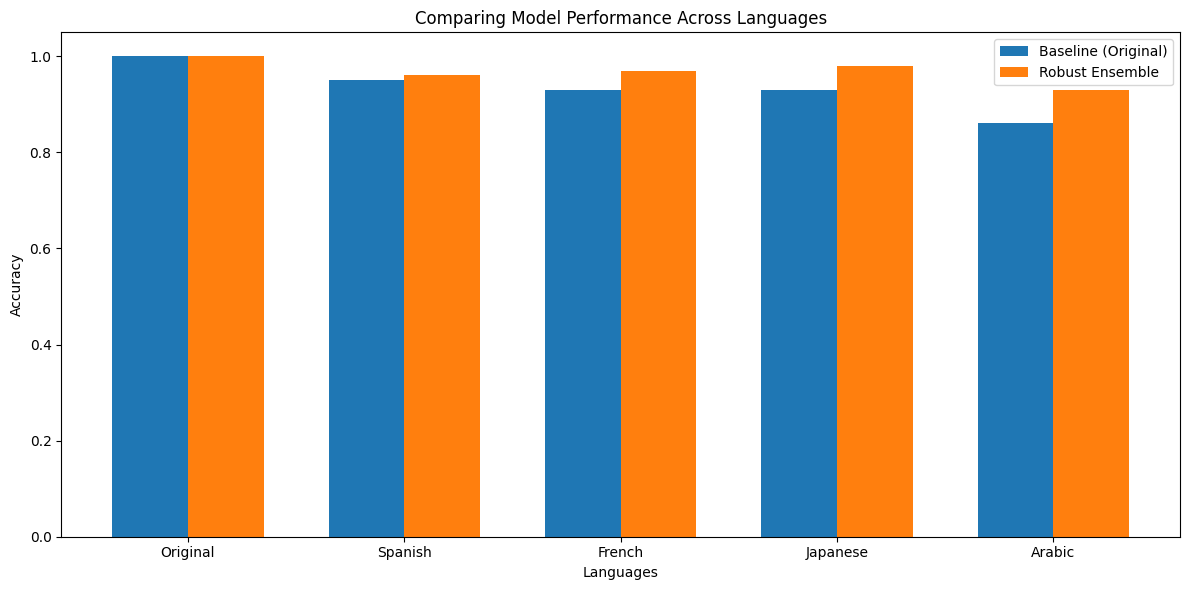

Detailed Classification Report for Japanese:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        41
           2       1.00      1.00      1.00        20
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00        13
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         8
           7       1.00      0.90      0.95        10

    accuracy                           0.98       101
   macro avg       0.97      0.96      0.96       101
weighted avg       0.98      0.98      0.98       101



In [8]:
from sklearn.base import clone

X_original = X_dict['Original']
y_original = y_dict['Original']

robust_ensemble = RobustMultilingualEnsemble()
robust_ensemble.fit(X_original, y_original)

robust_results = {}
for lang in languages.keys():
    X_test = X_dict[lang]
    y_test = y_dict[lang]
    
    y_pred = robust_ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    robust_results[lang] = {
        'accuracy': accuracy,
        'report': report
    }

plt.figure(figsize=(12, 6))
baseline_acc = list(approach1_results.values())
robust_acc = [robust_results[lang]['accuracy'] for lang in languages.keys()]

bar_width = 0.35
x = np.arange(len(languages))

plt.bar(x - bar_width/2, baseline_acc, bar_width, label='Baseline (Original)')
plt.bar(x + bar_width/2, robust_acc, bar_width, label='Robust Ensemble')

plt.xlabel('Languages')
plt.ylabel('Accuracy')
plt.title('Comparing Model Performance Across Languages')
plt.xticks(x, languages.keys())
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detailed Classification Report for Japanese:")
print(robust_results['Japanese']['report'])


### 9. Feature Importance Analysis Across Languages

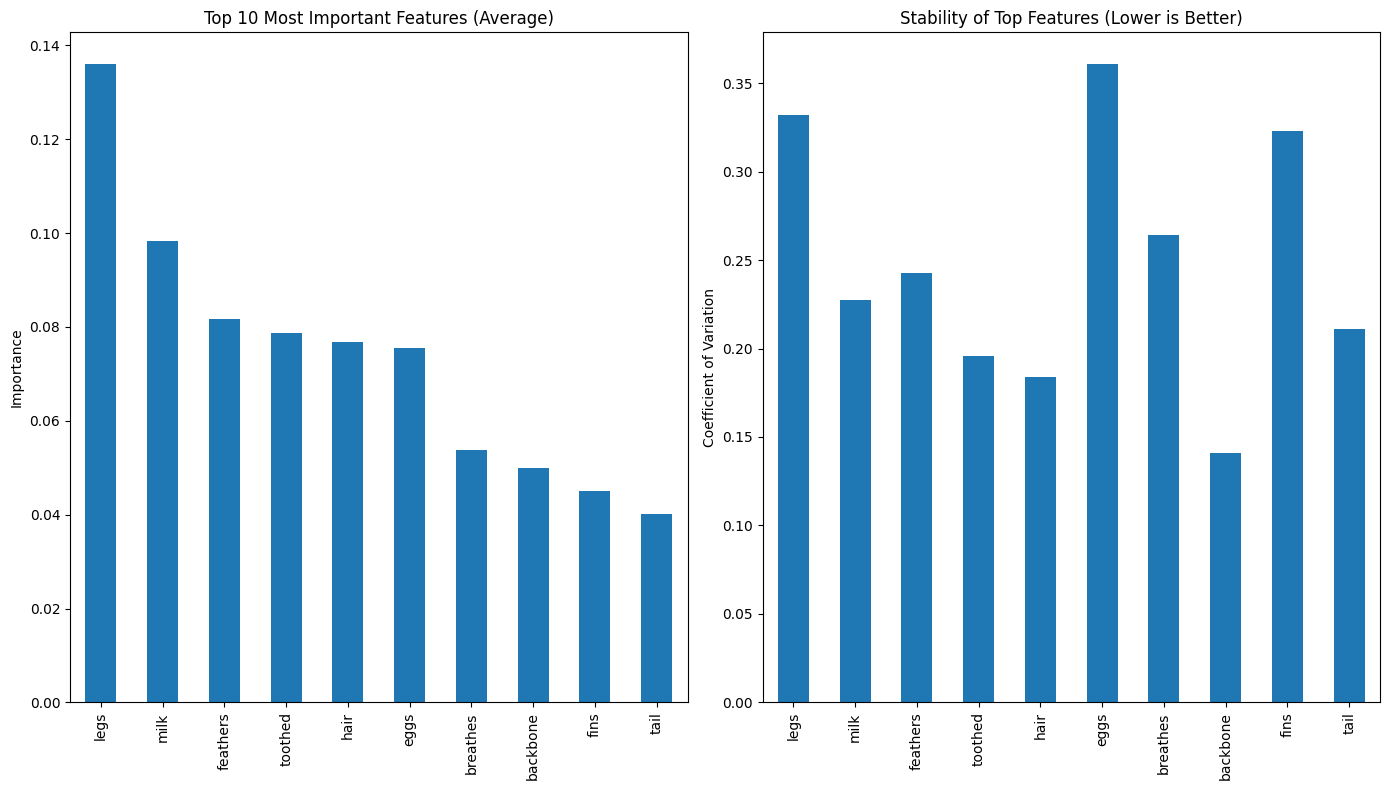

In [9]:
def analyze_feature_importance_stability():
    # Train a Random Forest on each language dataset
    feature_importance_by_lang = {}
    
    for lang in languages.keys():
        X = X_dict[lang]
        y = y_dict[lang]
        
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        
        feature_importance_by_lang[lang] = model.feature_importances_
    
    # Create a DataFrame for easier analysis
    importance_df = pd.DataFrame(feature_importance_by_lang, index=X.columns)
    
    # Calculate stability (standard deviation across languages)
    importance_df['std'] = importance_df.std(axis=1)
    importance_df['mean'] = importance_df.mean(axis=1)
    importance_df['coefficient_of_variation'] = importance_df['std'] / importance_df['mean']
    
    # Sort by mean importance
    importance_df = importance_df.sort_values('mean', ascending=False)
    
    return importance_df

# Get and visualize importance stability
importance_stability = analyze_feature_importance_stability()

# Plot top features and their stability
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
importance_stability['mean'].head(10).plot(kind='bar')
plt.title('Top 10 Most Important Features (Average)')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
importance_stability['coefficient_of_variation'].head(10).plot(kind='bar')
plt.title('Stability of Top Features (Lower is Better)')
plt.ylabel('Coefficient of Variation')

plt.tight_layout()
plt.show()


### 10. Build a Multilingual Zoo Classifier

In [10]:
def build_final_robust_classifier():
    # Combine data from all languages for training
    X_combined = pd.concat([X_dict[lang] for lang in languages.keys()])
    y_combined = pd.concat([y_dict[lang] for lang in languages.keys()])
    
    # Feature selection based on stability analysis
    stable_features = importance_stability[importance_stability['coefficient_of_variation'] < 0.3].index.tolist()
    
    X_combined_stable = X_combined[stable_features]
    
    # Build ensemble of models
    models = {
        'rf': RandomForestClassifier(n_estimators=100, random_state=42),
        'gb': GradientBoostingClassifier(random_state=42),
        'svm': SVC(probability=True, random_state=42),
        'knn': KNeighborsClassifier(n_neighbors=5)
    }
    
    # Create voting classifier
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in models.items()],
        voting='soft'
    )
    
    # Train the model
    ensemble.fit(X_combined_stable, y_combined)
    
    # Evaluate using cross-validation
    cv_scores = cross_val_score(ensemble, X_combined_stable, y_combined, cv=5)
    
    return {
        'model': ensemble,
        'stable_features': stable_features,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

# Build the final classifier
final_classifier = build_final_robust_classifier()

print(f"Final Robust Classifier CV Score: {final_classifier['cv_mean']:.4f} ± {final_classifier['cv_std']:.4f}")
print(f"Stable Features Used: {final_classifier['stable_features']}")


Final Robust Classifier CV Score: 0.8832 ± 0.0427
Stable Features Used: ['milk', 'feathers', 'toothed', 'hair', 'breathes', 'backbone', 'tail', 'aquatic', 'venomous']


### 11. Saving and Loading the Model

In [11]:
import joblib

# Save the model and preprocessing information
model_info = {
    'model': final_classifier['model'],
    'stable_features': final_classifier['stable_features'],
    'cv_score': final_classifier['cv_mean']
}

joblib.dump(model_info, 'multilingual_zoo_classifier.pkl')

# Example of loading and using the model
def load_and_predict(data_sample):
    # Load the model info
    loaded_info = joblib.load('multilingual_zoo_classifier.pkl')
    model = loaded_info['model']
    stable_features = loaded_info['stable_features']
    X = data_sample[stable_features]
    prediction = model.predict(X)
    probabilities = model.predict_proba(X)
    
    return prediction, probabilities
